# MNIST Supervised Classifcation Example in Flax

This notebook is based on Flax's official [Annoted MNIST](https://flax.readthedocs.io/en/latest/notebooks/annotated_mnist.html)
and [MNIST Example](https://github.com/google/flax/tree/main/examples/mnist).

But has been written to be a slightly more general Supervised Classification example. 
Primarily for educational purposes and reusability in other examples.

A really nice thing about this example is the use of the TrainState-object. We are able to bundle many necessary variables and functions with this object and can simply pass that around to our different functions. 

## 1. Imports

Import JAX, [JAX NumPy](https://jax.readthedocs.io/en/latest/jax.numpy.html),
Flax, ordinary NumPy, and TensorFlow Datasets (TFDS). Flax can use any
data-loading pipeline and this example demonstrates how to utilize TFDS.

In [8]:
import jax
import jax.numpy as jnp                # JAX NumPy

from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np                     # Ordinary NumPy
import optax                           # Optimizers
import tensorflow_datasets as tfds     # TFDS for MNIST
from ipywidgets import IntProgress

In [9]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [10]:
jax.devices()

## 2. Define network

Create a convolutional neural network with the Linen API by subclassing
[`Module`](https://flax.readthedocs.io/en/latest/flax.linen.html#core-module-abstraction).
Because the architecture in this example is relatively simple—you're just
stacking layers—you can define the inlined submodules directly within the
`__call__` method and wrap it with the
[`@compact`](https://flax.readthedocs.io/en/latest/flax.linen.html#compact-methods)
decorator.

In [11]:
class CNN(nn.Module):
    """A simple CNN model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.log_softmax(x)
        return x

In [94]:
class CNNEmbedding(nn.Module):
    """A simple CNN model."""

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        return x

## 3. Define loss

Define a cross-entropy loss function using just
[`jax.numpy`](https://jax.readthedocs.io/en/latest/jax.numpy.html)
that takes the model's logits and label vectors and returns a scalar loss. The
labels can be one-hot encoded with
[`jax.nn.one_hot`](https://jax.readthedocs.io/en/latest/_autosummary/jax.nn.one_hot.html),
as demonstrated below.

Note that for demonstration purposes, we return `nn.log_softmax()` from
the model and then simply multiply these (normalized) logits with the labels. In our
`examples/mnist` folder we actually return non-normalized logits and then use
`optax.softmax_cross_entropy()` to compute the loss, which has the same result.

In [12]:
def cross_entropy_loss(*, logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * logits, axis=-1))

## 4. Metric computation

For loss and accuracy metrics, create a separate function:

In [26]:
def compute_metrics(*, logits, labels):
    loss = cross_entropy_loss(logits=logits, labels=labels)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        'loss': loss,
        'accuracy' : accuracy
    }
    return metrics

## 5. Loading data

Define a function that loads and prepares the MNIST dataset and converts the
samples to floating-point numbers.

In [27]:
def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder('mnist')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    train_ds['image'] = jnp.float32(train_ds['image']) / 255.
    test_ds['image'] = jnp.float32(test_ds['image']) / 255.
    return train_ds, test_ds

## 6. Create train state

A common pattern in Flax is to create a single dataclass that represents the
entire training state, including step number, parameters, and optimizer state.

Also adding optimizer & model to this state has the advantage that we only need
to pass around a single argument to functions like `train_step()` (see below).

Because this is such a common pattern, Flax provides the class
[flax.training.train_state.TrainState](https://flax.readthedocs.io/en/latest/flax.training.html#train-state)
that serves most basic usecases. Usually one would subclass it to add more data
to be tracked, but in this example we can use it without any modifications.

In [28]:
def create_train_state(model, rng, learning_rate, momentum, sample):
    params = model.init(rng, jnp.ones(np.shape([sample])))['params'] 
    tx = optax.sgd(learning_rate, momentum)
    return train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

## 7. Training step

A function that:

- Evaluates the neural network given the parameters and a batch of input images
  with the
  [`Module.apply`](https://flax.readthedocs.io/en/latest/flax.linen.html#flax.linen.Module.apply)
  method.
- Computes the `cross_entropy_loss` loss function.
- Evaluates the loss function and its gradient using
  [`jax.value_and_grad`](https://jax.readthedocs.io/en/latest/jax.html#jax.value_and_grad).
- Applies a
  [pytree](https://jax.readthedocs.io/en/latest/pytrees.html#pytrees-and-jax-functions)
  of gradients to the optimizer to update the model's parameters.
- Computes the metrics using `compute_metrics` (defined earlier).

Use JAX's [`@jit`](https://jax.readthedocs.io/en/latest/jax.html#jax.jit)
decorator to trace the entire `train_step` function and just-in-time compile
it with [XLA](https://www.tensorflow.org/xla) into fused device operations
that run faster and more efficiently on hardware accelerators.

In [29]:
@jax.jit
def train_step(state, X, y):
    """Train for a single step."""
    def loss_fn(params):
        logits = state.apply_fn({'params' : params}, X)
        loss = cross_entropy_loss(logits=logits, labels=y)
        return loss, logits
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=y)
    return state, metrics

## 8. Evaluation step

Create a function that evaluates your model on the test set with
[`Module.apply`](https://flax.readthedocs.io/en/latest/flax.linen.html#flax.linen.Module.apply)

In [30]:
@jax.jit
def eval_step(state, X, y):
    logits = state.apply_fn({'params': state.params}, X)
    return compute_metrics(logits=logits, labels=y)

## 9. Train function

Define a training function that:

- Shuffles the training data before each epoch using
  [`jax.random.permutation`](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.permutation.html)
  that takes a PRNGKey as a parameter (check the
  [JAX - the sharp bits](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#JAX-PRNG)).
- Runs an optimization step for each batch.
- Retrieves the training metrics from the device with `jax.device_get` and
  computes their mean across each batch in an epoch.
- Returns the optimizer with updated parameters and the training loss and
  accuracy metrics.

In [31]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
    """Train for a single epoch."""
    train_ds_size = len(train_ds['X'])
    steps_per_epoch = train_ds_size // batch_size
    
    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size)) # perms are indices 
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm] for k, v in train_ds.items()} # v[perm, ...] ? 
        state, metrics = train_step(state, X=batch['X'], y=batch['y'])
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {k: np.mean([metrics[k] 
                        for metrics in batch_metrics_np])
                        for k in batch_metrics_np[0]}

    return state

## 10. Eval function

Create a model evaluation function that:

- Retrieves the evaluation metrics from the device with `jax.device_get`.
- Copies the metrics
  [data stored](https://flax.readthedocs.io/en/latest/design_notes/linen_design_principles.html#how-are-parameters-represented-and-how-do-we-handle-general-differentiable-algorithms-that-update-stateful-variables)
  in a JAX
  [pytree](https://jax.readthedocs.io/en/latest/pytrees.html#pytrees-and-jax-functions).

In [32]:
def eval_model(state, X, y):
    metrics = eval_step(state, X, y)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    return summary['loss'], summary['accuracy']

## 11. Download data

In [33]:
train_ds, test_ds = get_datasets()
train_ds = {'X' : train_ds['image'], 'y' : train_ds['label']}
test_ds  = {'X' : test_ds['image'] , 'y' : test_ds['label']}

## 12. Seed randomness

- Get one
  [PRNGKey](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.PRNGKey.html#jax.random.PRNGKey)
  and
  [split](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.split.html#jax.random.split)
  it to get a second key that you'll use for parameter initialization. (Learn
  more about
  [PRNG chains](https://flax.readthedocs.io/en/latest/design_notes/linen_design_principles.html#how-are-parameters-represented-and-how-do-we-handle-general-differentiable-algorithms-that-update-stateful-variables)
  and
  [JAX PRNG design](https://github.com/google/jax/blob/main/design_notes/prng.md).)

In [108]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

## 13. Initialize train state

Remember that function initializes both the model parameters and the optimizer
and puts both into the training state dataclass that is returned.

In [109]:
lr = 0.01
m = 0.7
sample = train_ds['X'][0]
print(np.shape([sample]))

(1, 28, 28, 1)


In [110]:
state = create_train_state(model=CNN(), rng=init_rng, learning_rate=lr, momentum=m, sample=sample)
del init_rng  # Must not be used anymore.

In [111]:
def visualize_layers(params):
    for layer_params in params.items():
        print("Layer Name : {}".format(layer_params[0]))
        weights, biases = layer_params[1]["kernel"], layer_params[1]["bias"]
        print("\tLayer Weights : {}, Biases : {}".format(weights.shape, biases.shape))

In [112]:
# Visualize layers
visualize_layers(state.params)

Layer Name : Conv_0
	Layer Weights : (3, 3, 1, 32), Biases : (32,)
Layer Name : Conv_1
	Layer Weights : (3, 3, 32, 64), Biases : (64,)
Layer Name : Dense_0
	Layer Weights : (3136, 256), Biases : (256,)
Layer Name : Dense_1
	Layer Weights : (256, 10), Biases : (10,)


## 14. Train and evaluate

Once the training and testing is done after 10 epochs, the output should show that your model was able to achieve approximately 99% accuracy.

In [113]:
num_epochs = 10
batch_size = 128

In [114]:
history = {'loss' : [], 'val_loss' : [], 'epochs' : [], 'accuracy' : [], 'val_accuracy' : []}

for epoch in range(1, num_epochs + 1):
    # Use a separate PRNG key to permute image data during shuffling
    rng, input_rng = jax.random.split(rng)
    # Run an optimization step over a training batch
    state = train_epoch(state, train_ds, batch_size, epoch, input_rng)
    # Evaluate on the test set after each training epoch 
    loss, accuracy = eval_model(state, X=train_ds['X'], y=train_ds['y'])
    val_loss, val_accuracy = eval_model(state, X=test_ds['X'], y=test_ds['y'])
    history['loss'].append(loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(accuracy)
    history['val_accuracy'].append(val_accuracy)
    history['epochs'].append(epoch)
    print('epoch: {} | loss: {:.5f} | val_loss: {:.5f} | accuracy: {:.2f} | val_accuracy {:.2f} |'.format(
      epoch, loss, val_loss, accuracy * 100, val_accuracy * 100))

epoch: 1 | loss: 0.27720 | val_loss: 0.25795 | accuracy: 91.65 | val_accuracy 92.36 |
epoch: 2 | loss: 0.18799 | val_loss: 0.17443 | accuracy: 94.27 | val_accuracy 94.62 |
epoch: 3 | loss: 0.13956 | val_loss: 0.12979 | accuracy: 95.91 | val_accuracy 96.07 |
epoch: 4 | loss: 0.11496 | val_loss: 0.11098 | accuracy: 96.59 | val_accuracy 96.63 |
epoch: 5 | loss: 0.09876 | val_loss: 0.09450 | accuracy: 97.07 | val_accuracy 97.21 |
epoch: 6 | loss: 0.08171 | val_loss: 0.08129 | accuracy: 97.54 | val_accuracy 97.47 |
epoch: 7 | loss: 0.07375 | val_loss: 0.07385 | accuracy: 97.78 | val_accuracy 97.67 |
epoch: 8 | loss: 0.06790 | val_loss: 0.06991 | accuracy: 97.95 | val_accuracy 97.77 |
epoch: 9 | loss: 0.05801 | val_loss: 0.05998 | accuracy: 98.25 | val_accuracy 98.07 |
epoch: 10 | loss: 0.06321 | val_loss: 0.06952 | accuracy: 98.04 | val_accuracy 97.69 |


In [115]:
# apply_fn was defined above to be CNN().apply()
print(state.__dict__.keys())

dict_keys(['step', 'apply_fn', 'params', 'tx', 'opt_state'])


In [116]:
@jax.jit
def predict(state, X):
    y_pred_logits = state.apply_fn({'params' : state.params}, X)
    return nn.softmax(y_pred_logits), jnp.argmax(y_pred_logits, -1)

In [117]:
y_pred_proba, y_pred = predict(state=state, X=test_ds['X'])

In [118]:
y_test = test_ds['y']

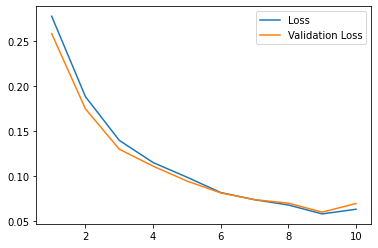

In [119]:
import matplotlib.pyplot as plt
plt.plot(history['epochs'], history['loss'], label='Loss')
plt.plot(history['epochs'], history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

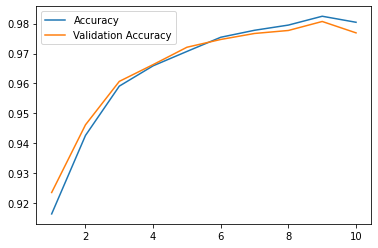

In [120]:
import matplotlib.pyplot as plt
plt.plot(history['epochs'], history['accuracy'], label='Accuracy')
plt.plot(history['epochs'], history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [121]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.95      0.99      0.97      1010
           4       0.99      0.95      0.97       982
           5       0.96      0.99      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.99      0.95      0.97       974
           9       0.96      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



## Embeddings Visualization

In [122]:
embedding_params = {k : v for k, v in state.params.items() if k != 'Dense_1'}

In [123]:
embedding = CNNEmbedding().apply({'params' : embedding_params}, test_ds['X'])

In [124]:
embedding.shape

(10000, 256)

In [125]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
labels = test_ds['y']
latent = pca.fit_transform(embedding)

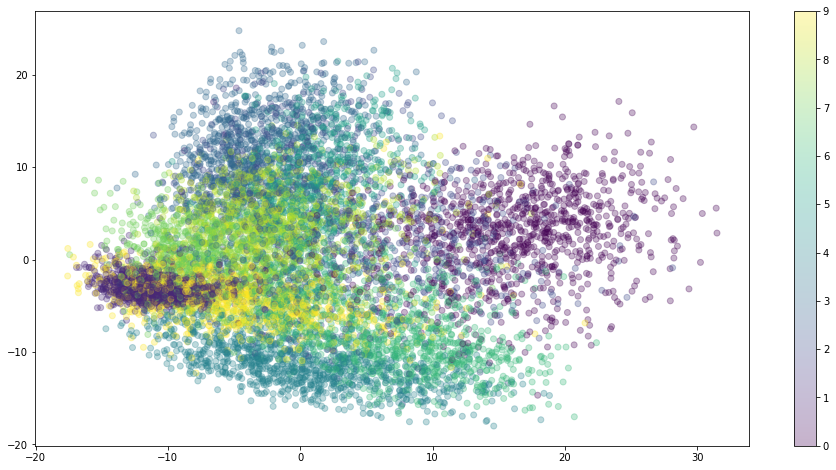

In [126]:
fig = plt.figure(figsize=(16,8))
p = plt.scatter(latent[:,0], latent[:,1], alpha=.3, c=labels)
fig.colorbar(p)
plt.show()